In [247]:
import os
import cv2
import pickle
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import svm
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def ld_images(folder):
    images=[]
    for file in sorted(os.listdir(folder)):
        image = cv2.imread(os.path.join(folder,file))
        if image is not None:
            images.append(image)
    return np.asarray(images)

def trait_diff(traits):
    n = traits.shape[0]
    ones = np.full((int(n / 4)), 1)
    minus_ones = np.full((int(n / 2) - int(n / 4)), -1)
    labels = np.r_[ones, minus_ones]
    k = 0
    diff = []
    for i in range(0,n,2):
        if(labels[k] == 1):
            diff.append(traits[i+1] - traits[i])
        else:
            diff.append(traits[i] - traits[i+1])
        k += 1
    diff = np.array(diff)
    return diff, labels

def plot_graph(train, test, type):
    x = range(1,len(train)+1)
    red_line = mlines.Line2D([], [], color='red', marker='o', label='Train Data')
    green_line = mlines.Line2D([], [], color='green', marker='o', label='Test Data')
    plt.plot(x, train, 'ro-')
    plt.plot(x, test, 'go-')
    plt.title(str(type)+" Graph")
    plt.legend(handles = [red_line, green_line])
    plt.show()

In [258]:
best_models = pickle.load(open('1.2_best_models.pkl', 'rb'))

In [272]:
all_gov_rgb = ld_images("img-elec/governor")
all_gov_hog = []
for i in range(len(all_gov_rgb)):
    all_gov_rgb[i] = cv2.cvtColor(all_gov_rgb[i], cv2.COLOR_BGR2RGB)
    fd, hog_image = hog(all_gov_rgb[i], orientations = 32, pixels_per_cell = (16, 16), cells_per_block = (1,1), visualize = True, multichannel = True)
    all_gov_hog.append(fd)

all_sen_rgb = ld_images("img-elec/senator")
all_sen_hog = []
for i in range(len(all_sen_rgb)):
    all_sen_rgb[i] = cv2.cvtColor(all_sen_rgb[i], cv2.COLOR_BGR2RGB)
    fd, hog_image = hog(all_sen_rgb[i], orientations = 32, pixels_per_cell = (16, 16), cells_per_block = (1,1), visualize = True, multichannel = True)
    all_sen_hog.append(fd)

d:\python36\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [273]:
stat_gov = sio.loadmat('stat-gov.mat')
gov_landmark = stat_gov['face_landmark']
gov_vote_diff = stat_gov['vote_diff']

stat_sen = sio.loadmat('stat-sen.mat')
sen_landmark = stat_sen['face_landmark']
sen_vote_diff = stat_sen['vote_diff']

gov_features = np.c_[all_gov_hog, gov_landmark]
sen_features = np.c_[all_sen_hog, sen_landmark]

gov_features = minmax_scale(gov_features, axis = 0)
sen_features = minmax_scale(sen_features, axis = 0)

In [274]:
print(gov_features[101,-11])
print(gov_features[100,-11])
print(sen_features[100,-11])
print(sen_features[101,-11])

0.7908062952832591
0.5532643552177507
0.4720823441079176
0.325060007323577


In [275]:
gov_traits = []
sen_traits = []
for i in range(14):
    gov_traits.append(best_models[i].predict(gov_features))
    sen_traits.append(best_models[i].predict(sen_features))
gov_traits = np.array(gov_traits).T
sen_traits = np.array(sen_traits).T

gov_diff, gov_labels = trait_diff(gov_traits)
sen_diff, sen_labels = trait_diff(sen_traits)

In [276]:
gov_diff = minmax_scale(gov_diff, axis = 0)
sen_diff = minmax_scale(sen_diff, axis = 0)

In [277]:
gov_train_diff, gov_test_diff, gov_train_labels, gov_test_labels = train_test_split(gov_diff, gov_labels, test_size=0.2, random_state=35, shuffle = True)
sen_train_diff, sen_test_diff, sen_train_labels, sen_test_labels = train_test_split(sen_diff, sen_labels, test_size=0.2, random_state=5, shuffle = True)

c_range = 2**np.linspace(-5,13, num=10)
train_accuracy = []
test_accuracy = []
best_parameters = []

In [278]:
svc = svm.LinearSVC(fit_intercept = False, loss = 'hinge')
parameters = {'C':c_range}
clf = GridSearchCV(svc, parameters, cv = 10, n_jobs = -1, scoring = 'accuracy', iid=True, verbose = True)
clf.fit(gov_train_diff, gov_train_labels)
train_pred = clf.predict(gov_train_diff)
test_pred = clf.predict(gov_test_diff)
train_accuracy.append(accuracy_score(gov_train_labels, train_pred))
test_accuracy.append(accuracy_score(gov_test_labels, test_pred))
best_parameters.append(clf.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  77 out of 100 | elapsed:    4.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
d:\python36\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [279]:
svc = svm.LinearSVC(fit_intercept = False, loss = 'hinge')
parameters = {'C':c_range}
clf = GridSearchCV(svc, parameters, cv = 10, n_jobs = -1, scoring = 'accuracy', iid=True, verbose = True)
clf.fit(sen_train_diff, sen_train_labels)
train_pred = clf.predict(sen_train_diff)
test_pred = clf.predict(sen_test_diff)
train_accuracy.append(accuracy_score(sen_train_labels, train_pred))
test_accuracy.append(accuracy_score(sen_test_labels, test_pred))
best_parameters.append(clf.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
d:\python36\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Accuracy:
 [0.8181818181818182, 0.717391304347826]
Test Accuracy:
 [0.75, 0.5833333333333334]
Best Parameters:
 [{'C': 128.0}, {'C': 8.0}]


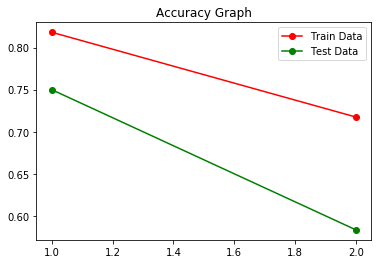

In [280]:
print("Train Accuracy:\n",train_accuracy)
print("Test Accuracy:\n",test_accuracy)
print("Best Parameters:\n",best_parameters)

plot_graph(train_accuracy,test_accuracy, "Accuracy")

In [285]:
print(best_models[0])
print(best_models[1])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'C': array([3.125e-02, 1.250e-01, 5.000e-01, 2.000e+00, 8.000e+00, 3.200e+01,
       1.280e+02, 5.120e+02, 2.048e+03, 8.192e+03]), 'epsilon': array([1.95312e-03, 7.81250e-03, 3.12500e-02, 1.25000e-01, 5.00000e-01,
       2.00000e+00]), 'gamma': array([7.62939e-06, 3.05176e-05, 1.22070e-04, 4.88281e-04, 1.95312e-03,
       7.81250e-03, 3.12500e-02, 1.25000e-01, 5.00000e-01, 2.00000e+00,
       8.00000e+00, 3.20000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', 